# Classical Inference Analysis

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm


In [13]:
train = pd.read_csv("../data/raw/new_train.csv", index_col="Id")

# Read all numeric dtypes
numeric_df = train.select_dtypes(include=[np.number]).copy()

# Drop ordinal and coded categorical variables
numerical_df = numeric_df.drop(columns=[
    "MSSubClass",
    "OverallQual",
    "OverallCond",
    "MoSold"
])


In [14]:
# show all columns, don’t wrap
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
# Basic descriptive statistics
desc_stats = numerical_df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print(desc_stats)
# Descriptive statistics for SalePrice only
# saleprice_stats = numerical_df['SalePrice'].describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
# print("\nDescriptive Statistics for SalePrice:\n", saleprice_stats)


                        mean           std      min       25%       50%       75%       max
MSZoning            3.028767      0.632017      0.0       3.0       3.0       3.0       4.0
LotFrontage        69.863699     22.027677     21.0      60.0      69.0      79.0     313.0
LotArea         10516.828082   9981.264932   1300.0    7553.5    9478.5   11601.5  215245.0
Street              0.995890      0.063996      0.0       1.0       1.0       1.0       1.0
Alley               0.028082      0.165264      0.0       0.0       0.0       0.0       1.0
...                      ...           ...      ...       ...       ...       ...       ...
MiscVal            43.489041    496.123024      0.0       0.0       0.0       0.0   15500.0
YrSold           2007.815753      1.328095   2006.0    2007.0    2008.0    2009.0    2010.0
SaleType            7.513014      1.552100      0.0       8.0       8.0       8.0       8.0
SaleCondition       3.770548      1.100854      0.0       4.0       4.0       4.

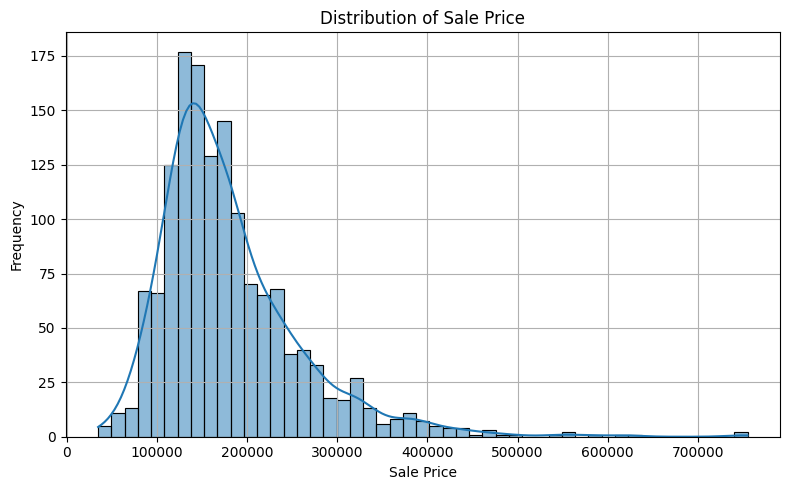

In [15]:
# Histogram of SalePrice
plt.figure(figsize=(8, 5))
sns.histplot(numerical_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


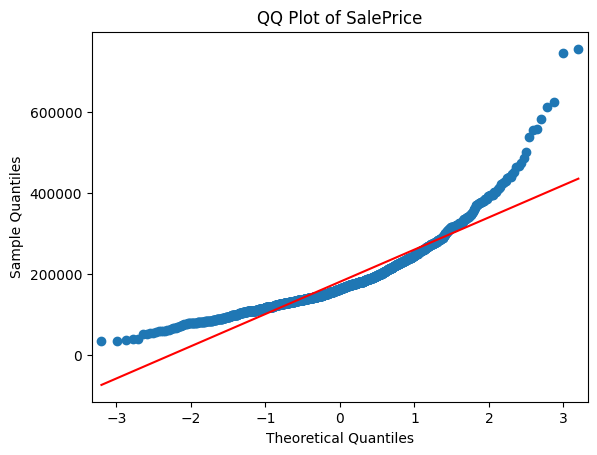

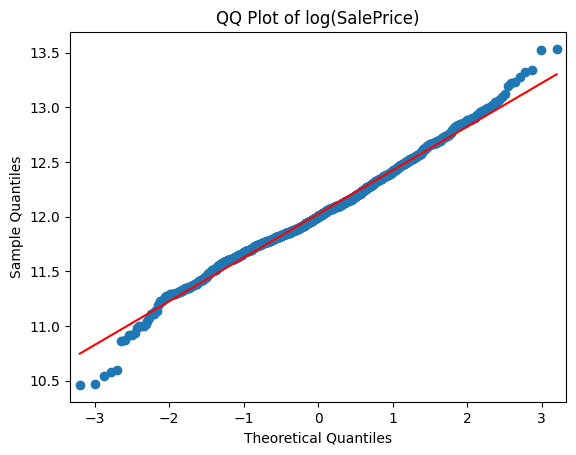

In [16]:
sm.qqplot(numerical_df['SalePrice'], line='s')
plt.title("QQ Plot of SalePrice")
plt.show()
numerical_df['LogSalePrice'] = np.log(numerical_df['SalePrice'])
# QQ-Plot to assess normality
sm.qqplot(numerical_df['LogSalePrice'], line='s')
plt.title("QQ Plot of log(SalePrice)")
plt.show()


### What We See in the QQ Plot

- The points **deviate upward** at the high end (right tail) — this indicates **positive skewness** (a long tail of high sale prices).
- There is also some **deviation at the low end** — possibly due to outliers or mild left-skew artifacts.
- The middle portion is **roughly linear**, which is a good sign, but the **tails deviate significantly**, suggesting that the distribution is **not normal**.

### Why Use a Log Transformation?

Applying a logarithmic transformation to variables like `SalePrice` is useful when the data is **positively skewed** (long tail of high values). It helps:

- **Reduce skewness** and make the distribution more symmetric.
- **Stabilize variance**, especially when large values dominate the range.
- Improve the performance and assumptions of models that expect normally distributed inputs or residuals (e.g., Linear Regression, ARIMA).

In practice, using `log(SalePrice)` often leads to better-fitting and more interpretable models.



In [17]:
# 95% Confidence Interval for SalePrice mean
sample_mean = numerical_df['SalePrice'].mean()
sample_std = numerical_df['SalePrice'].std()
n = len(numerical_df['SalePrice'])
conf_int = stats.t.interval(0.95, df=n-1, loc=sample_mean, scale=sample_std/np.sqrt(n))

print(f"\n95% Confidence Interval for SalePrice Mean: {conf_int[0]:,.2f} to {conf_int[1]:,.2f}")



95% Confidence Interval for SalePrice Mean: 176,842.84 to 184,999.55


### What can we deduce from that ?
The confidence interval is quite small if we take into account that we are speaking of a mean `SalePrice`of 185'000, it represents a bit more than 5%.


In [18]:
# J'arrive pas à dire si cette cell est vraiment utile ou pas, on a déjà un calcul de la moyenne 

# Hypothesis Test: Is the average SalePrice > $180,000?
# H0: mu = 180000, H1: mu > 180000
t_stat, p_value = stats.ttest_1samp(numerical_df['SalePrice'], popmean=180000)

print(f"\nT-statistic: {t_stat:.3f}")
print(f"One-tailed p-value (mean > 180000): {p_value / 2:.4f}")

if t_stat > 0 and (p_value / 2) < 0.05:
    print("Result: Reject H0 — The average SalePrice is significantly greater than $180,000.")
else:
    print("Result: Fail to reject H0 — No significant evidence that SalePrice > $180,000.")



T-statistic: 0.443
One-tailed p-value (mean > 180000): 0.3289
Result: Fail to reject H0 — No significant evidence that SalePrice > $180,000.


In [19]:
# Tu l'as mis que c'était optionel mais vraiment je pense qu'on s'en bat littéralement les couilles des confidence intervals des autres features

# Optional: Compute confidence intervals for other features
def feature_confidence_intervals(df, confidence=0.95):
    results = {}
    for col in df.columns:
        data = df[col]
        mean = data.mean()
        std = data.std()
        n = len(data)
        ci = stats.t.interval(confidence, df=n-1, loc=mean, scale=std/np.sqrt(n))
        results[col] = (round(ci[0], 2), round(ci[1], 2))
    return pd.DataFrame(results, index=[f'{int(confidence*100)}% CI Lower', f'{int(confidence*100)}% CI Upper']).T

ci_table = feature_confidence_intervals(numerical_df)
print("\nConfidence Intervals for Numerical Features:")
print(ci_table)



Confidence Intervals for Numerical Features:
               95% CI Lower  95% CI Upper
MSZoning               3.00          3.06
LotFrontage           68.73         70.99
LotArea            10004.42      11029.24
Street                 0.99          1.00
Alley                  0.02          0.04
...                     ...           ...
YrSold              2007.75       2007.88
SaleType               7.43          7.59
SaleCondition          3.71          3.83
SalePrice         176842.84     184999.55
LogSalePrice          12.00         12.04

[77 rows x 2 columns]
